### Hurma Tanıma Sistemi

CNN kullanarak hurma tanıma sistemi geliştirilmiştir. Kullanılan veri seti ve kaynaklar aşağıda sunulmuştur.


Kaynak:

https://www.kaggle.com/datasets/muratkokludataset/date-fruit-datasets/code

KOKLU, M., KURSUN, R., TASPINAR, Y. S., and CINAR, I. (2021). Classification of Date Fruits into Genetic Varieties Using Image Analysis. Mathematical Problems in Engineering, Vol.2021, Article ID: 4793293, DOI:10.1155/2021/4793293

## Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from  tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
import tensorflow as tf
print(tf.__version__)

2.16.1


## Veri Yükleme

In [3]:
#Dosya yolu ve etiketlerden dataframe oluşturma fonksiyonu
def create_dataset(folders,path):
    data = {'imgpath': [], 'labels': []}
    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath, file)
            data['imgpath'].append(filepath)
            data['labels'].append(folder)

    dataset = pd.DataFrame(data)
    return dataset

In [4]:
ls '/kaggle/input/date-fruit-image-dataset-in-controlled-environment'

 Ajwa/     Medjool/  'Nabtat Ali'/   Shaishe/   Sugaey/
 Galaxy/   Meneifi/   Rutab/         Sokari/


In [5]:
path1='/kaggle/input/date-fruit-image-dataset-in-controlled-environment'
folders1=  ["Ajwa",  "Medjool",  "Nabtat Ali",  "Shaishe",   "Sugaey",
 "Galaxy",  "Meneifi",   "Rutab", "Sokari"]

df=create_dataset(folders1,path1)

In [6]:
df.head()

,imgpath,labels
0,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
1,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
2,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
3,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
4,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa


In [7]:
# Veri seti bilgileri
print('-- Veri seti bilgileri --\n')
print(f'Görsel Sayısı: {df.shape[0]}\n')
print(f'Etiket sayısı: {len(df.labels.unique())}\n')
print(f'Etiketler {df.labels.unique()}')

-- Veri seti bilgileri --

Görsel Sayısı: 1658

Etiket sayısı: 9

Etiketler ['Ajwa' 'Medjool' 'Nabtat Ali' 'Shaishe' 'Sugaey' 'Galaxy' 'Meneifi'
 'Rutab' 'Sokari']


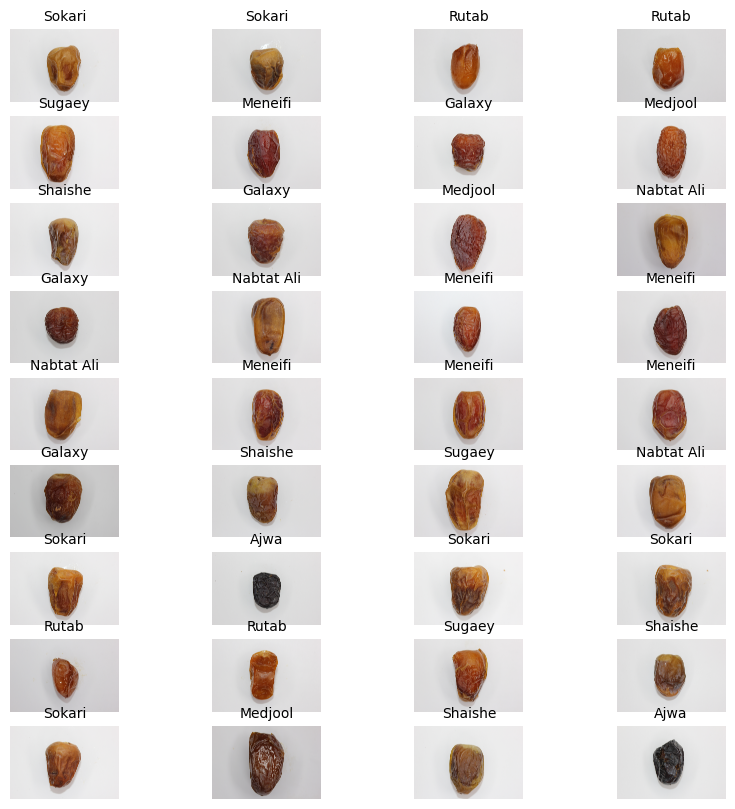

In [8]:
#Veri görselleştirme
import random
import matplotlib.gridspec as gridspec
from PIL import Image
rows=9
cols=4

selected_indices=random.sample(range(len(df)),rows*cols)
fig,axes=plt.subplots(rows,cols,figsize=(10,10))
gs=gridspec.GridSpec(rows,cols,wspace=0.1,hspace=0.1)

for i,idx in enumerate(selected_indices):
    row=i//cols
    col=i%cols
    img_path=df['imgpath'].iloc[idx]
    label=df['labels'].iloc[idx]
    img=Image.open(img_path)
    axes[row,col].imshow(img)
    axes[row,col].axis('off')
    axes[row,col].set_title(label,fontsize=10)
plt.show()

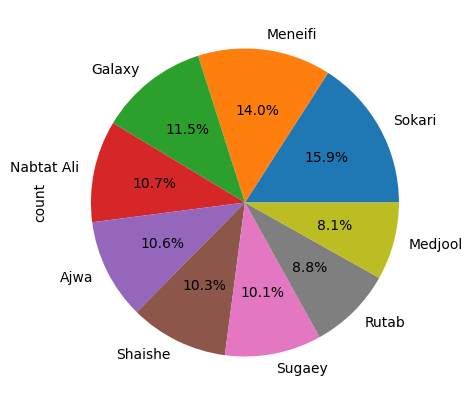

In [9]:
# pie plot label distribution
df.labels.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5,5));

In [10]:
from sklearn.model_selection import train_test_split

# Veri setini etiketlere göre bölme
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['labels'])

train_df.shape, val_df.shape, test_df.shape

((1326, 2), (166, 2), (166, 2))

In [11]:
%%time
# görsel ön işleme ve generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed = 42 #random state=42
batch_size = 64
img_size = (224, 224)

generator = ImageDataGenerator(rescale = 1./255)

train_data = generator.flow_from_dataframe(train_df, x_col = 'imgpath', y_col = 'labels', 
                                           color_mode = 'rgb', class_mode = 'categorical', 
                                           batch_size = batch_size, target_size = img_size, 
                                           shuffle = True, seed = seed)

val_data = generator.flow_from_dataframe(val_df, x_col = 'imgpath', y_col = 'labels', 
                                         color_mode = 'rgb', class_mode = 'categorical', 
                                         batch_size = batch_size, target_size = img_size, 
                                         shuffle = False)

test_data = generator.flow_from_dataframe(test_df, x_col = 'imgpath', y_col = 'labels', 
                                          color_mode = 'rgb', class_mode = 'categorical', 
                                          batch_size = batch_size, target_size = img_size, 
                                          shuffle = False)

Found 1326 validated image filenames belonging to 9 classes.
Found 166 validated image filenames belonging to 9 classes.
Found 166 validated image filenames belonging to 9 classes.
CPU times: user 56 ms, sys: 62.1 ms, total: 118 ms
Wall time: 3.07 s


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy

model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))  # 9 kategori

# Modelin derlenmesi
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])#kategorik etiketler varsa loss = 'CategoricalCrossentropy()'

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,108,297 (19.49 MB)

 Trainable params: 5,108,297 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
%%time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# En düşük loss değerinde eğitimin durmasını sağla
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

history = model.fit(train_data, validation_data = val_data, 
                    epochs = 20, callbacks = [model_es, model_rlr])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 248s 9s/step - accuracy: 0.1299 - loss: 2.3013 - val_accuracy: 0.3072 - val_loss: 1.7040 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 192s 7s/step - accuracy: 0.3602 - loss: 1.6267 - val_accuracy: 0.6205 - val_loss: 1.0532 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.6225 - loss: 1.0295 - val_accuracy: 0.7831 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step - accuracy: 0.7680 - loss: 0.6474 - val_accuracy: 0.8253 - val_loss: 0.4677 - learning_rate: 0.0010
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step - accuracy: 0.8167 - loss: 0.5493 - val_accuracy: 0.7892 - val_loss: 0.6020 - learning_rate: 0.0010
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 179s 7s/step - accuracy: 0.8375 - loss: 0.4680 - val_accuracy: 0.8916 - val_loss: 0.3509 - learning_rate: 2.0000e-04
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 180s 7s/step - accuracy: 0.9138 - loss: 0.3076 - val_accuracy: 